<a href="https://colab.research.google.com/github/seamalt/GNN_TCell/blob/main/PPI_GCN_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GCN-Based Multi-Label Prediction of Protein Gene Ontology (GO) in PYG PPI Dataset
The code below is a basic proof of concept to evaluate the properties of proteins in the PYG PPI dataset using a ConvGCN framework with batch normalization, dropout, and nonlinear functions (ReLU).
The purpose of this proof of concept is to experimentally determine the effects of GCN model architecture on accuracy and recall, which will serve as a foundation for building a knowledge graph of biomolecular interactions in T-Cells as part of a virtual cell-based research project.

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

!pip install torch-geometric

from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv
from torch_geometric.transforms import NormalizeFeatures

from sklearn.metrics import confusion_matrix
import numpy as np


In [26]:
class GraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels=64, num_layers=2, out_channels=121, dropout=0.5):
        super().__init__()

        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()

        # Layer 1
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        self.norms.append(nn.BatchNorm1d(hidden_channels))

        # Hidden Layers (each convolution looks at max depth K of the tree for interactions)
        for _ in range(num_layers - 1):
          self.convs.append(SAGEConv(hidden_channels, hidden_channels))
          self.norms.append(nn.BatchNorm1d(hidden_channels))

        # Layer 3?
        # self.convs.append(GCNConv(hidden_channels, hidden_channels))
        # self.norms.append(nn.BatchNorm1d(hidden_channels))

        # Output layer
        self.lin = nn.Linear(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        for conv, norm in zip(self.convs, self.norms):
            x = conv(x, edge_index)
            x = norm(x)
            x = F.elu(x)
            # x = F.dropout(x, p=self.dropout, training=self.training)

        embeddings = x
        # embeddings = F.dropout(embeddings, p=self.dropout, training=self.training)
        out = self.lin(embeddings)
        # print(f"Embeddings stats: mean={embeddings.abs().mean():.6f}, dead={(embeddings==0).float().mean():.2%}")
        return out, embeddings


In [27]:
transform = NormalizeFeatures()

train_dataset = PPI(root="data/PPI", split="train", transform=transform)
val_dataset   = PPI(root="data/PPI", split="val", transform=transform)
test_dataset  = PPI(root="data/PPI", split="test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=2)
test_loader  = DataLoader(test_dataset, batch_size=2)


In [28]:
print(f"Train graphs: {len(train_dataset)}")
print(f"Val graphs:   {len(val_dataset)}")
print(f"Test graphs:  {len(test_dataset)}")
print(f"Node features: {train_dataset.num_features}")
print(f"Classes: {train_dataset.num_classes}")

Train graphs: 20
Val graphs:   2
Test graphs:  2
Node features: 50
Classes: 121


adjust parameters for model here:

In [71]:
hidden_channels=256
k=5
dropout=0.2
lr=0.001
epochs = 40

In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GraphSAGE(
    in_channels=train_dataset.num_features,
    hidden_channels=hidden_channels,
    num_layers=k,
    dropout=dropout,
    out_channels=train_dataset.num_classes
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)

# decreases lr with time
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.5,
    patience=2,
    min_lr=1e-5
)

criterion = nn.BCEWithLogitsLoss()


In [73]:
from sklearn.metrics import roc_auc_score

def evaluate(loader): # micro-averaged evaluator for true label, false label, or false pos/false neg
    model.eval()

    total_loss = 0
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)

            logits, _ = model(data.x, data.edge_index)
            loss = criterion(logits, data.y)
            total_loss += loss.item()

            probs = torch.sigmoid(logits) # use roc-auc curve to investigate the viability of 0.5 as a threshold
            all_probs.append(probs.cpu())
            all_labels.append(data.y.cpu().int())

    all_probs = torch.cat(all_probs, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()

    auc = roc_auc_score(all_labels, all_probs, average="micro")
    # cm = confusion_matrix(all_labels, all_probs)

    return total_loss / len(loader), auc #, cm


In [67]:
train_aucs = []
val_aucs = []
test_aucs = []

for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()

        logits, embeddings = model(data.x, data.edge_index)
        loss = criterion(logits, data.y)
        # scheduler.step(val_auc)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_loss, train_auc = evaluate(train_loader)
    val_loss, val_auc = evaluate(val_loader)
    test_loss, test_auc = evaluate(test_loader)

    scheduler.step(test_auc) # adjust learning rate based on validated data
    train_aucs.append(train_auc)
    test_aucs.append(test_auc)
    val_aucs.append(val_auc)

    print(f"""
Epoch {epoch:03d}
---------------------------
Train Loss: {train_loss:.4f} | Train Auc: {train_auc:.4f}
Val   Loss: {val_loss:.4f} | Val   Auc: {val_auc:.4f}
Test  Loss: {test_loss:.4f} | Test  Auc: {test_auc:.4f}
""")





Epoch 001
---------------------------
Train Loss: 0.6521 | Train Auc: 0.6461
Val   Loss: 0.6500 | Val   Auc: 0.6501
Test  Loss: 0.6505 | Test  Auc: 0.6506


Epoch 002
---------------------------
Train Loss: 0.5907 | Train Auc: 0.6315
Val   Loss: 0.5804 | Val   Auc: 0.6367
Test  Loss: 0.5830 | Test  Auc: 0.6363


Epoch 003
---------------------------
Train Loss: 0.6183 | Train Auc: 0.6266
Val   Loss: 0.5975 | Val   Auc: 0.6320
Test  Loss: 0.6038 | Test  Auc: 0.6313


Epoch 004
---------------------------
Train Loss: 0.6143 | Train Auc: 0.6585
Val   Loss: 0.5901 | Val   Auc: 0.6618
Test  Loss: 0.5961 | Test  Auc: 0.6617


Epoch 005
---------------------------
Train Loss: 0.7702 | Train Auc: 0.6808
Val   Loss: 0.7431 | Val   Auc: 0.6800
Test  Loss: 0.7516 | Test  Auc: 0.6808


Epoch 006
---------------------------
Train Loss: 0.5845 | Train Auc: 0.7119
Val   Loss: 0.5723 | Val   Auc: 0.7063
Test  Loss: 0.5749 | Test  Auc: 0.7091


Epoch 007
---------------------------
Train Loss: 0.6804 

Epochs:  40
Hidden Channels:  256
K (Conv Layers):  5
Dropout Rate:  0.2 (not implemented)
Learning Rate:  0.001


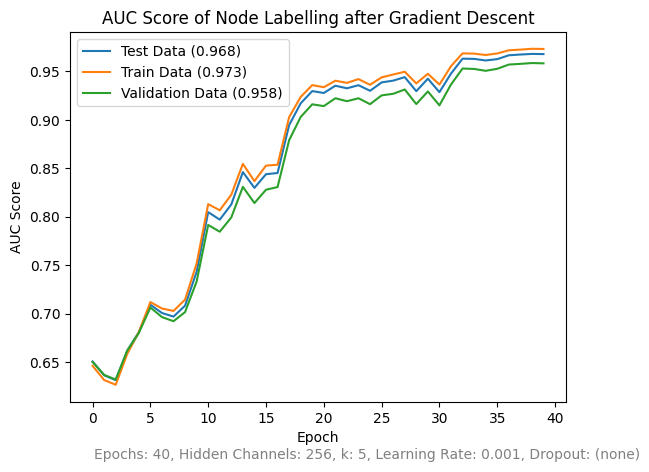

In [91]:
import matplotlib.pyplot as plt

print("Epochs: ", len(test_aucs))
print("Hidden Channels: ", hidden_channels)
print("K (Conv Layers): ", k)
print("Dropout Rate: ", dropout, "(not implemented)")
print("Learning Rate: ", lr)
plt.plot(test_aucs, label=f"Test Data ({test_aucs[-1]:.3f})")
plt.plot(train_aucs, label=f"Train Data ({train_aucs[-1]:.3f})")
plt.plot(val_aucs, label=f"Validation Data ({val_aucs[-1]:.3f})")
plt.xlabel("Epoch")
plt.ylabel("AUC Score")
plt.title("AUC Score of Node Labelling after Gradient Descent")
plt.text(0.1, 0.55, f'Epochs: {len(test_aucs)}, Hidden Channels: {hidden_channels}, k: {k}, Learning Rate: {lr}, Dropout: (none)'
, color='gray')
plt.legend()

In [43]:
# _, _, test_cm = evaluate(test_loader)

# print("Confusion Matrix (Micro-averaged over all labels):")
# print(test_cm)

# precision = test_cm[1, 1] / (test_cm[1, 1] + test_cm[0, 1])
# recall = test_cm[1, 1] / (test_cm[1, 1] + test_cm[1, 0])

# f1_score = 2 * (precision * recall) / (precision + recall)
# print("f1: ",f1_score)

# confusion matrix (removed for clarity due to incompatibility with multi-label problem)

### Visualizing Output Embeddings (to see what's going on)
Using PCA to reduce dimensionality of data to 2D to see the differences in clusters between the 121 labels

### improvements to model:
* changed evaluation criteria to use auc-roc score (averaging auc score (likelihood that true sample will be ranked as more likely than false sample) -- area calculation determined by roc curve).
  * auc scores are averaged for each 121 labels (protein function labels).
* added learning rate decay (since performance converges at ~80% with vanilla GCN, without SageGraph)
* increased graph complexity by increasing the number of layers from 2-3, which increased performance from ~80% to ~87%
* increasing graph complexity to 5 layers somehow did not cause overfitting/oversmoothing and performance jumped to 95-98%?


---

* <font color="red">why do all testsets improve at the same rate, do I happen to be splitting data wrong and training on all data (including test data)?
  * otherwise, the data suggests no overfitting or oversmoothing since similarly high accuracies on all dataset partitions.</font>

# next task: link prediction on protein interactions

As a simple extension of the first GCN analysis, the following code determines the *existence* of connections between nodes, which ultimately allows the PPI (homogeneous dataset) to determine predictions between the existence of protein interactions.

In future steps, more robust datasets will be used which have heterogeneous data. This means that links between nodes can be encoded with multiple features (rather than existence vs no existence), which can encode relational properties which will be needed for our knowledge graph.

In [92]:
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

In [93]:
def get_link_data(data, val_ratio=0.1, test_ratio=0.1):
  #gathering link data, split into validation and test, since not originally provided by PPI dataset
    edge_index = data.edge_index
    num_edges = edge_index.size(1)

    perm = torch.randperm(num_edges)
    num_val = int(num_edges * val_ratio)
    num_test = int(num_edges * test_ratio)

    val_edges = edge_index[:, perm[:num_val]]
    test_edges = edge_index[:, perm[num_val:num_val + num_test]]
    train_edges = edge_index[:, perm[num_val + num_test:]]

    return train_edges, val_edges, test_edges

In [94]:
# a high prediction is produced from a high value generated from a dot product between
# nodes A and B that make the link. A low dot product means orthogonal, "dissimilar" properties
# which suggests to the model that there is less likelihood of a link.
def link_predict(embeddings, edge_index):
    src, dst = edge_index
    return (embeddings[src] * embeddings[dst]).sum(dim=1)

In [95]:
def evaluate_links(model, loader, return_scores=False):
    model.eval()

    all_scores = []
    all_labels = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            _, embeddings = model(data.x, data.edge_index)

            pos_edge_index = data.edge_index
            neg_edge_index = negative_sampling(
                pos_edge_index,
                num_nodes=data.num_nodes,
                num_neg_samples=pos_edge_index.size(1)
            )

            pos_scores = link_predict(embeddings, pos_edge_index)
            neg_scores = link_predict(embeddings, neg_edge_index)

            scores = torch.cat([pos_scores, neg_scores])
            labels = torch.cat([
                torch.ones(pos_scores.size(0)),
                torch.zeros(neg_scores.size(0))
            ]).to(device)

            all_scores.append(scores.cpu())
            all_labels.append(labels.cpu())

    scores = torch.cat(all_scores)
    labels = torch.cat(all_labels) #.numpy()

    probs = torch.sigmoid(scores)
    preds = (probs > 0.5).int() #.numpy()

    auc = roc_auc_score(labels, probs.numpy())
    acc = accuracy_score(labels, preds)
    cm = confusion_matrix(labels, preds)

    if return_scores:
        # return auc, probabilities, labels needed for building roc curve
        return auc, probs, labels
    else:
        # return auc, accuracy, and confusion matrix as metrics
        preds = (probs > 0.5).type(torch.int)
        acc = accuracy_score(labels, preds)
        cm = confusion_matrix(labels, preds)
        return auc, acc, cm

In [97]:
epochs = 30

lambda_link = 1.0  # weight of link loss

for epoch in range(1, epochs + 1):
    model.train()

    node_loss_total = 0
    link_loss_total = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()

        logits, embeddings = model(data.x, data.edge_index)

        # Node classification loss
        node_loss = criterion(logits, data.y)

        # Link prediction loss
        neg_edge_index = negative_sampling(
            data.edge_index,
            num_nodes=data.num_nodes,
            num_neg_samples=data.edge_index.size(1)
        )
        # negative sampling used (non-existent links are assigned a negative weight)

        pos_scores = link_predict(embeddings, data.edge_index)
        neg_scores = link_predict(embeddings, neg_edge_index)

        scores = torch.cat([pos_scores, neg_scores])
        labels = torch.cat([
            torch.ones(pos_scores.size(0)),
            torch.zeros(neg_scores.size(0))
        ]).to(device)

        link_loss = F.binary_cross_entropy_with_logits(scores, labels)

        loss = node_loss + lambda_link * link_loss
        loss.backward()
        optimizer.step()

        node_loss_total += node_loss.item()
        link_loss_total += link_loss.item()

    # Node classification metrics
    train_loss, train_acc = evaluate(train_loader)
    val_loss, val_acc = evaluate(val_loader)
    test_loss, test_acc = evaluate(test_loader)

    # Link prediction metrics
    train_auc, train_lacc, _ = evaluate_links(model, train_loader, return_scores=False)
    val_auc, val_lacc, _ = evaluate_links(model, val_loader, return_scores=False)
    test_auc, test_lacc, _ = evaluate_links(model, test_loader, return_scores=False)

    print(
        f"Epoch {epoch:03d} | "
        f"Node Loss: {train_loss:.3f}/{val_loss:.3f}/{test_loss:.3f} | Node Auc: {train_acc:.3f}/{val_acc:.3f}/{test_acc:.3f} | "
        f"Link AUC: {train_auc:.3f}/{val_auc:.3f}/{test_auc:.3f}"
    )

Epoch 001 | Node Loss: 0.627/0.624/0.624 | Node Auc: 0.636/0.638/0.639 | Link AUC: 0.504/0.503/0.505
Epoch 002 | Node Loss: 0.623/0.619/0.620 | Node Auc: 0.617/0.620/0.620 | Link AUC: 0.503/0.504/0.505
Epoch 003 | Node Loss: 0.653/0.649/0.650 | Node Auc: 0.546/0.549/0.549 | Link AUC: 0.505/0.505/0.506
Epoch 004 | Node Loss: 0.632/0.627/0.628 | Node Auc: 0.594/0.598/0.599 | Link AUC: 0.514/0.514/0.515
Epoch 005 | Node Loss: 0.609/0.603/0.604 | Node Auc: 0.655/0.657/0.658 | Link AUC: 0.636/0.642/0.639
Epoch 006 | Node Loss: 0.600/0.594/0.595 | Node Auc: 0.672/0.672/0.675 | Link AUC: 0.692/0.702/0.708
Epoch 007 | Node Loss: 0.606/0.600/0.601 | Node Auc: 0.678/0.678/0.681 | Link AUC: 0.726/0.720/0.729
Epoch 008 | Node Loss: 0.609/0.603/0.605 | Node Auc: 0.690/0.689/0.692 | Link AUC: 0.755/0.739/0.747
Epoch 009 | Node Loss: 0.618/0.610/0.612 | Node Auc: 0.691/0.691/0.693 | Link AUC: 0.791/0.761/0.770
Epoch 010 | Node Loss: 0.617/0.609/0.611 | Node Auc: 0.697/0.697/0.698 | Link AUC: 0.801/0.

KeyboardInterrupt: 

In [98]:
_, _, link_cm = evaluate_links(model, test_loader)

print("Link Prediction Confusion Matrix:")
print(link_cm)

precision = link_cm[1, 1] / (link_cm[1, 1] + link_cm[0, 1])
recall = link_cm[1, 1] / (link_cm[1, 1] + link_cm[1, 0])

f1_score = 2 * (precision * recall) / (precision + recall)
print("f1: ",f1_score)

Link Prediction Confusion Matrix:
[[ 16364 145612]
 [   238 161738]]
f1:  0.6892352011181992


Best threshold: 0.95052034
Sensitivity: 0.8463352595446239
Specificity: 0.792802637427767


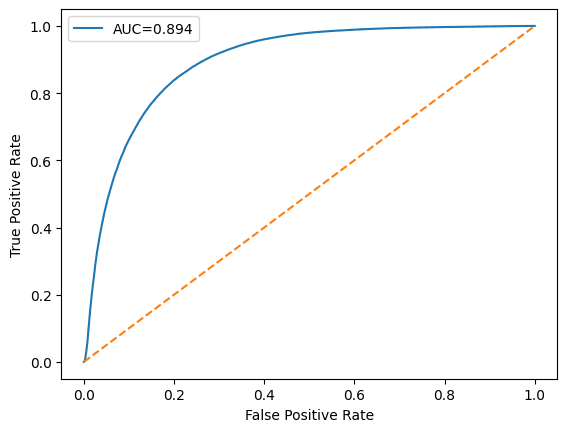

In [99]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

auc, probs, labels = evaluate_links(model, test_loader, return_scores=True)

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(labels, probs)


# Using Youden's J statistic to find the most ideal threshold for link prediction
# based on the maximal difference between true positive rate and false positive rate
j = tpr - fpr
best_idx = j.argmax()

best_threshold = thresholds[best_idx]
best_sensitivity = tpr[best_idx]
best_specificity = 1 - fpr[best_idx]

print("Best threshold:", best_threshold)
print("Sensitivity:", best_sensitivity)
print("Specificity:", best_specificity)

plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

note, we use AUC-ROC in our assessment of the sensitivity/specificity of our data since unlike F1 scores, it is not sensitive to class imbalance (differences in size between positive and negative dataset, affecting relative size of false positives and false negatives). We can also see our data without a threshold.

#final notes


* Why is the loss not increasing drastically per epoch, even if the accuracy seems to be getting better (marginally)? Is this overfitting at play?
* When the task is link prediction, the node classification does not improve, even though I would have thought they would improve together since the node classification (protein label) would likely infer information about the likelihood of interaction with another protein
* How come the F1 score for the first task (node classification) is so much worse than the F1 score for the second task, even with the class imbalance of task 2? Is there class imbalance with the first task since I'm tracking multilabel attributes? (should investigate -- because having vs not having a specific label is very likely to have a class imbalance -- may want to use roc-auc score for this as well)
* Should the actual architecture of the GCN be improved? 2 layers is likely the max number of conv layers I would want to have, but unsure about batch norm, relu (may want to switch to leaky relu), etc.  

# Comparing with Random Forest

### Node Classification

In [3]:
!pip install torch-geometric xgboost scikit-learn

import torch
from torch_geometric.datasets import PPI
from torch_geometric.utils import train_test_split_edges

In [4]:
# gather data from dataset (already sorted)
train_dataset = PPI(root='data/PPI', split='train')
val_dataset   = PPI(root='data/PPI', split='val')
test_dataset  = PPI(root='data/PPI', split='test')

Extracting data/PPI/ppi.zip
Processing...
Done!


In [5]:
import numpy as np

def extract_node_data(dataset):
    X, Y = [], []
    for data in dataset:
        X.append(data.x.numpy())
        Y.append(data.y.numpy())
    return np.vstack(X), np.vstack(Y)

In [6]:
X_train, Y_train = extract_node_data(train_dataset)
X_val,   Y_val   = extract_node_data(val_dataset)
X_test,  Y_test  = extract_node_data(test_dataset)

In [7]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

models = []
aucs = []

for label_idx in range(Y_train.shape[1]):
    model = XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        tree_method='hist'
    )

    model.fit(X_train, Y_train[:, label_idx])
    preds = model.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(Y_test[:, label_idx], preds)
    aucs.append(auc)
    models.append(model)

print(f"Mean Node Classification ROC-AUC: {np.mean(aucs):.4f}")

Mean Node Classification ROC-AUC: 0.6733
